In [1]:
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

project_dir = Path("/headless") / ".xschem" / "simulations"
data_dir = Path(".data")
img_dir = Path(".img")

if not project_dir.exists():
    print("Directory doesn't exist :(")
else:
    for thing in project_dir.iterdir():
        print (thing)

if not data_dir.exists():
    data_dir.mkdir()

if not img_dir.exists():
    img_dir.mkdir()

def save_cmd(device: str, attr: str):
    return f"save @m.x{device}.msky130_fd_pr__nfet_01v8[{attr}]"

def sky_retrieve(device: str, attr: str):
    return f"@m.x{device}.msky130_fd_pr__nfet_01v8[{attr}]"

def print_keys_length(res: dict):
    for key in res.keys(): print(f"{key: <40}: {len(res[key])} elements")

/headless/.xschem/simulations/ldo_gf180.spice
/headless/.xschem/simulations/test-ldo.spice
/headless/.xschem/simulations/gfamp.spice


## Análisis previo

In [41]:
file = project_dir / "nmos_intrinsic_gain_IPD413HW1.spice"
ns.source(file)

ERROR:ngspyce.sharedspice:Warning: m=xx on .subckt line will override multiplier m hierarchy!


### Revisión del dispositivo y modelo

Es ideal ser capaz de entender como acceder a los parámetros internos de un dispositivo.

In [83]:
print(ns.device_state("m.xm1.msky130_fd_pr__nfet_01v8").keys())
ns.device_state("m.xm1.msky130_fd_pr__nfet_01v8")["l"]

dict_keys(['description', 'device', 'model', 'l', 'w', 'm', 'nf', 'sa', 'sb', 'sd', 'sca', 'scb', 'scc', 'sc', 'min', 'ad', 'as', 'pd', 'ps', 'nrd', 'nrs', 'off', 'rbdb', 'rbsb', 'rbpb', 'rbps', 'rbpd', 'delvto', 'mulu0', 'xgw', 'ngcon', 'trnqsmod', 'acnqsmod', 'rbodymod', 'rgatemod', 'geomod', 'rgeomod', 'gmbs', 'gm', 'gds', 'vdsat', 'vth', 'id', 'ibd', 'ibs', 'gbd', 'gbs', 'isub', 'igidl', 'igisl', 'igs', 'igd', 'igb', 'igcs', 'igcd', 'vbs', 'vgs', 'vds', 'cgg', 'cgs', 'cgd', 'cbg', 'cbd', 'cbs', 'cdg', 'cdd', 'cds', 'csg', 'csd', 'css', 'cgb', 'cdb', 'csb', 'cbb', 'capbd', 'capbs', 'qg', 'qb', 'qd', 'qs', 'qinv', 'qdef', 'gcrg', 'gtau'])


1.5e-06

In [27]:
ns.model_parameters(model="nfet_01v8")

{'description': 'No matching instances or models'}

In [45]:
#ns.model_parameters(device="@m.xm1")

len(ns.model_parameters(device="m.xm1.msky130_fd_pr__nfet_01v8").keys())

754

In [48]:
ns.model_parameters(device="@m.xm1")

{'description': 'No matching instances or models'}

# Imágenes anteriores



| a | b |
|--|--|
| Transient Analysis | 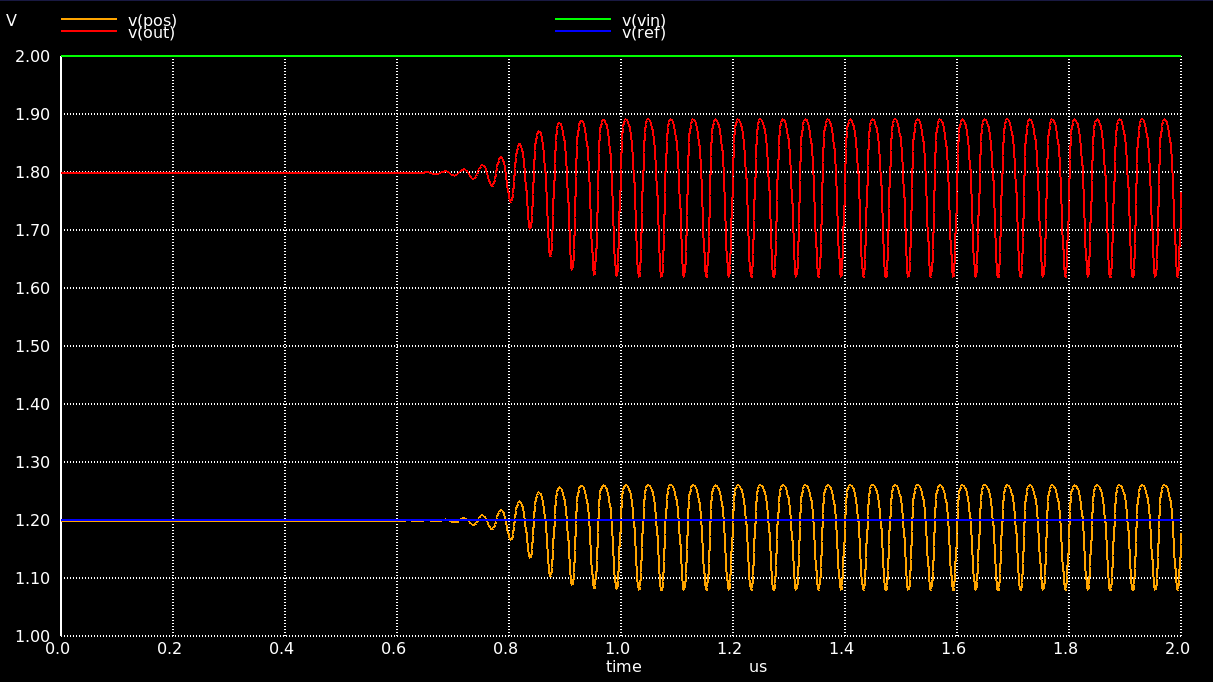 |
| Transient 24 us | 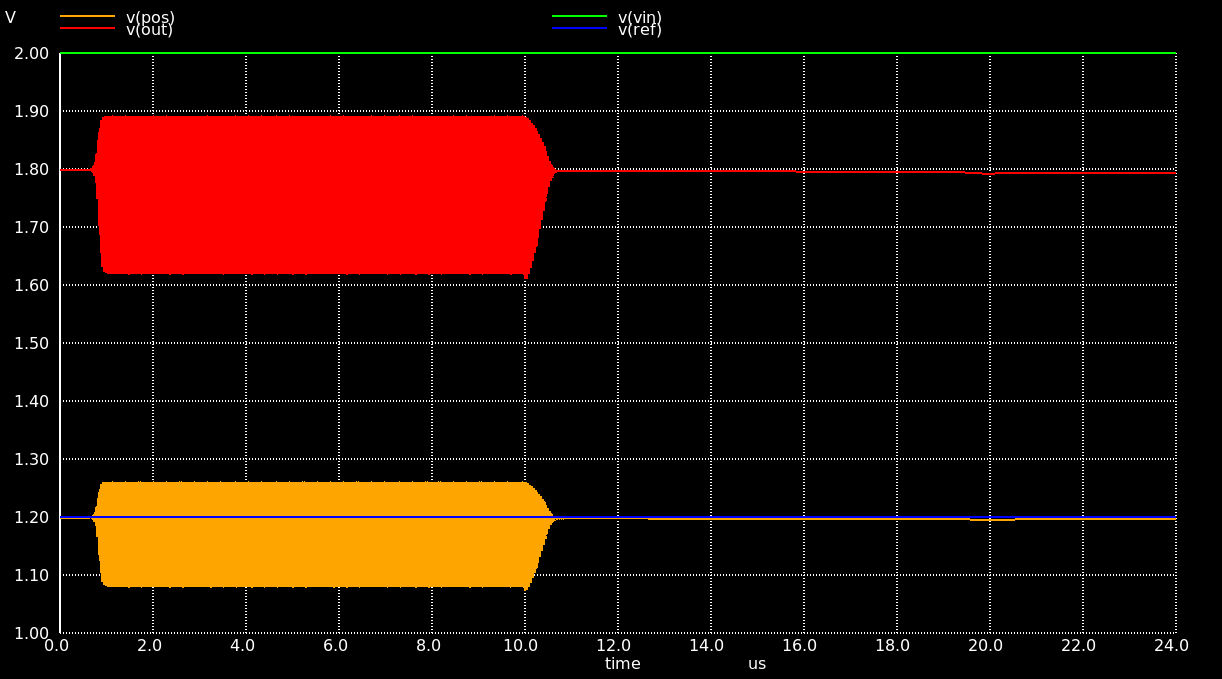 |
| PSRR | 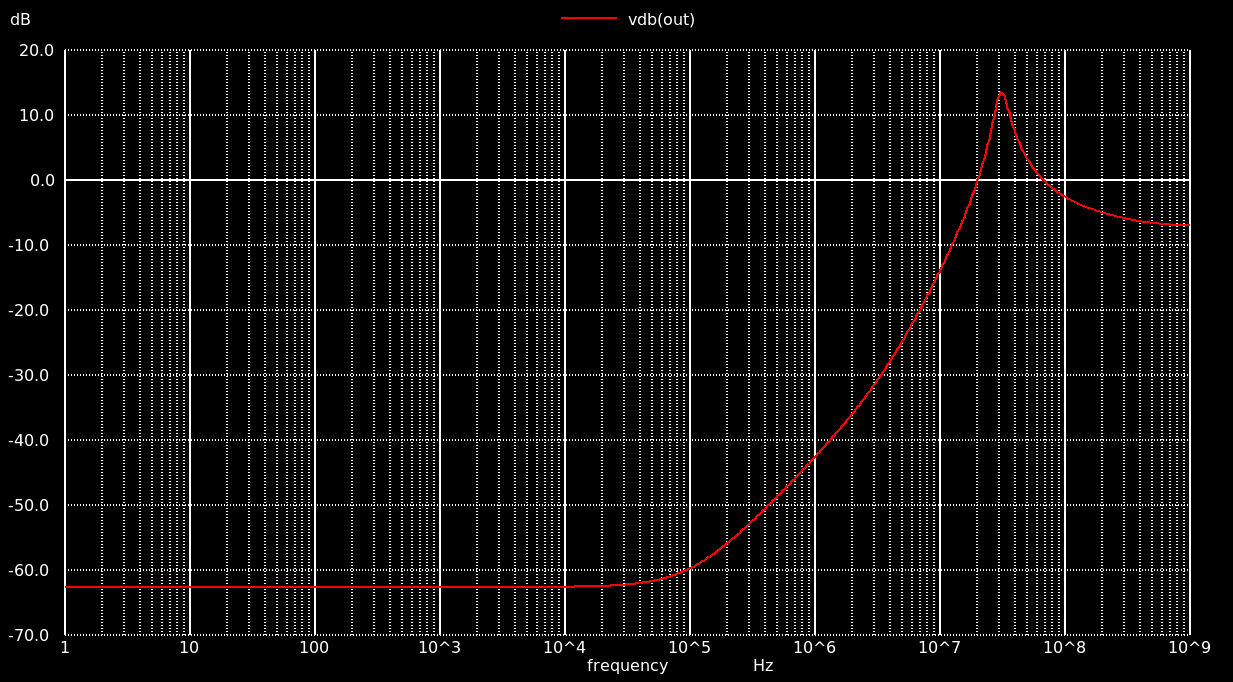 |
| VSweep |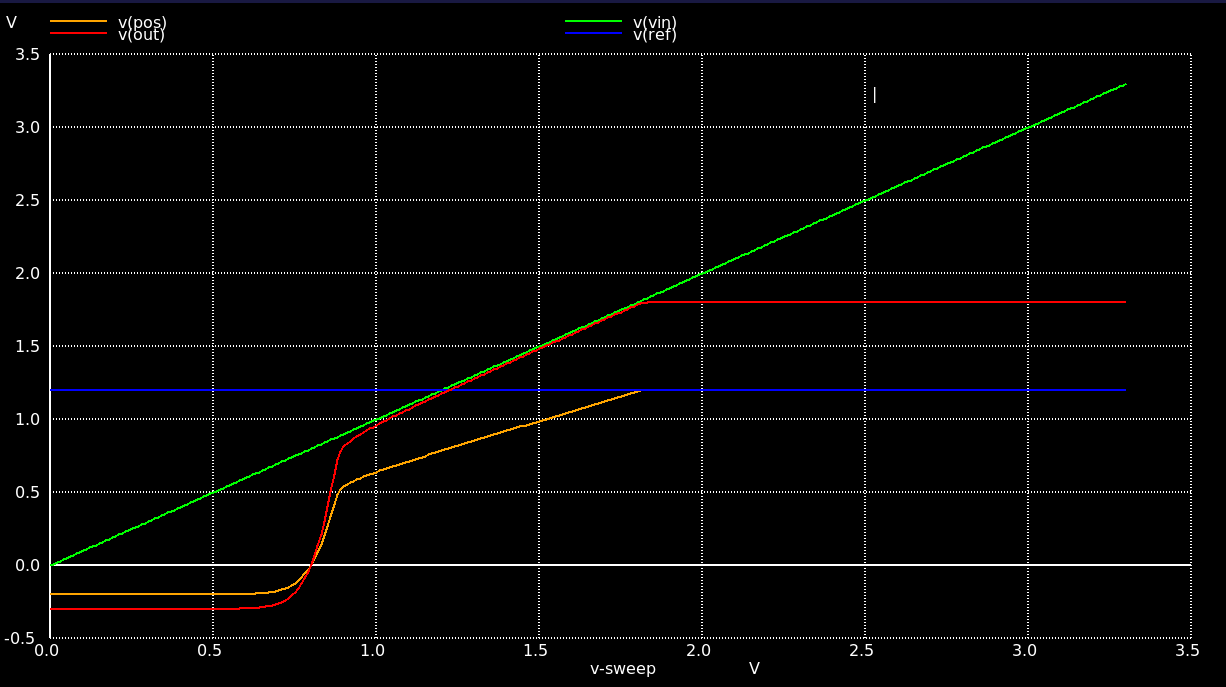 |



| Transient Analysis | PSRR Analysis | V Sweep Analysis |
|--|--|--|
| 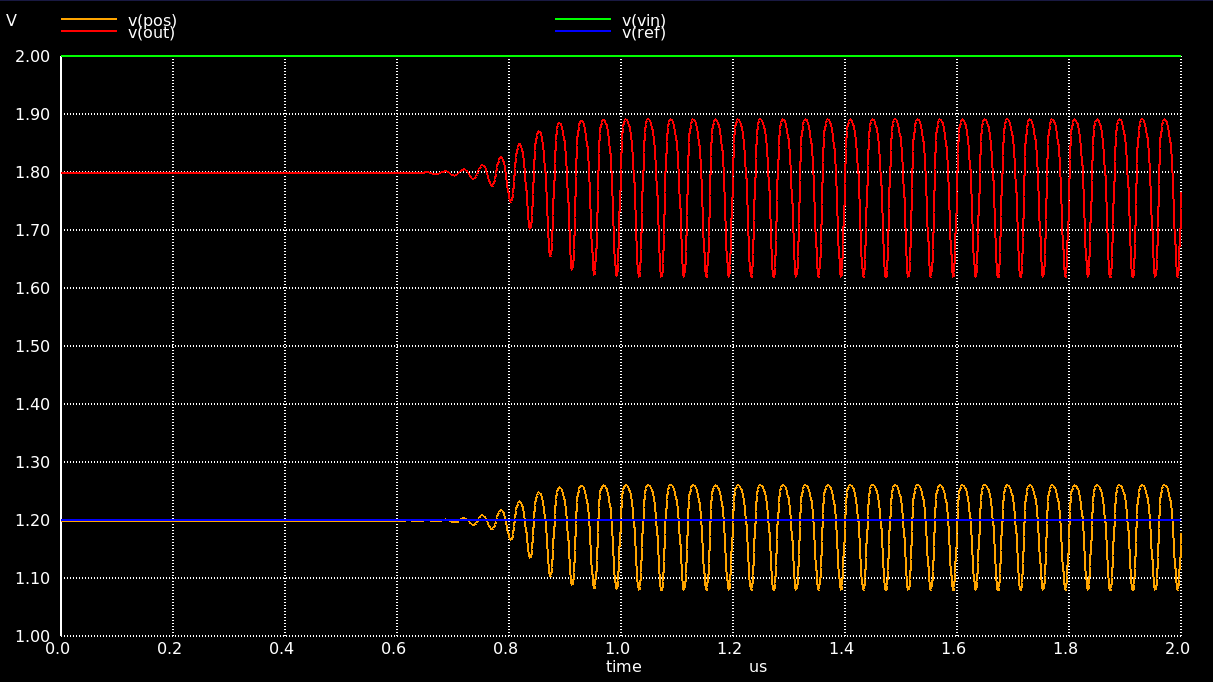 | 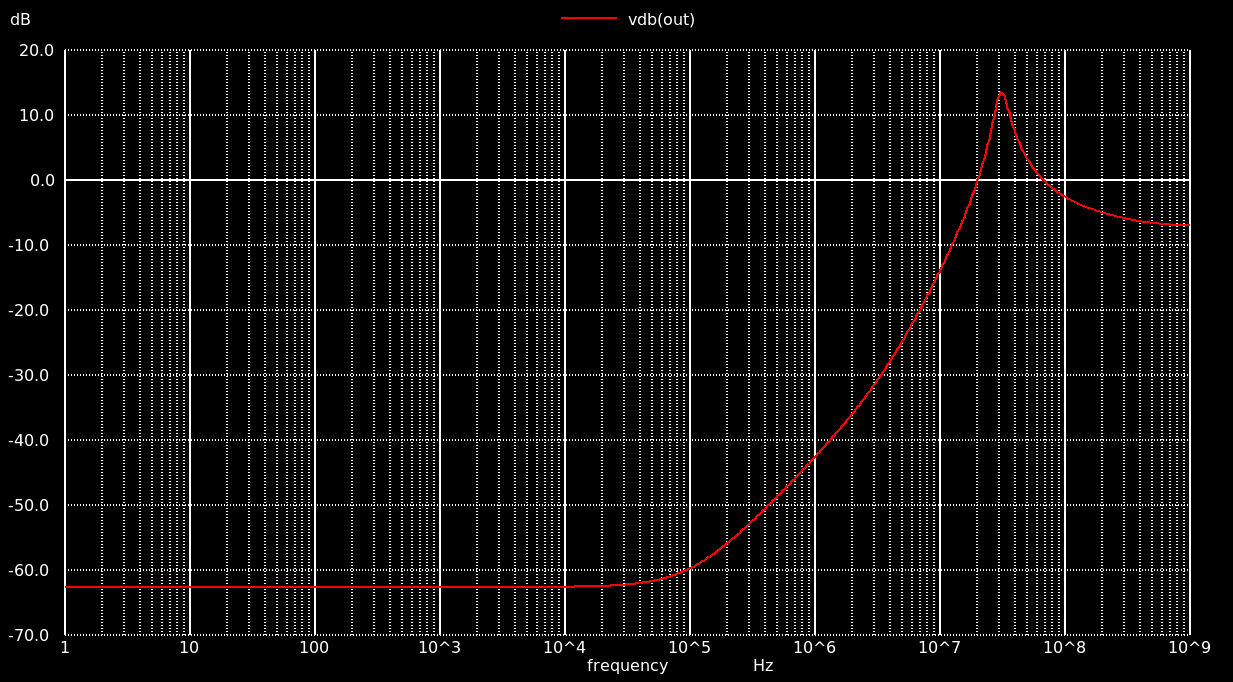 | 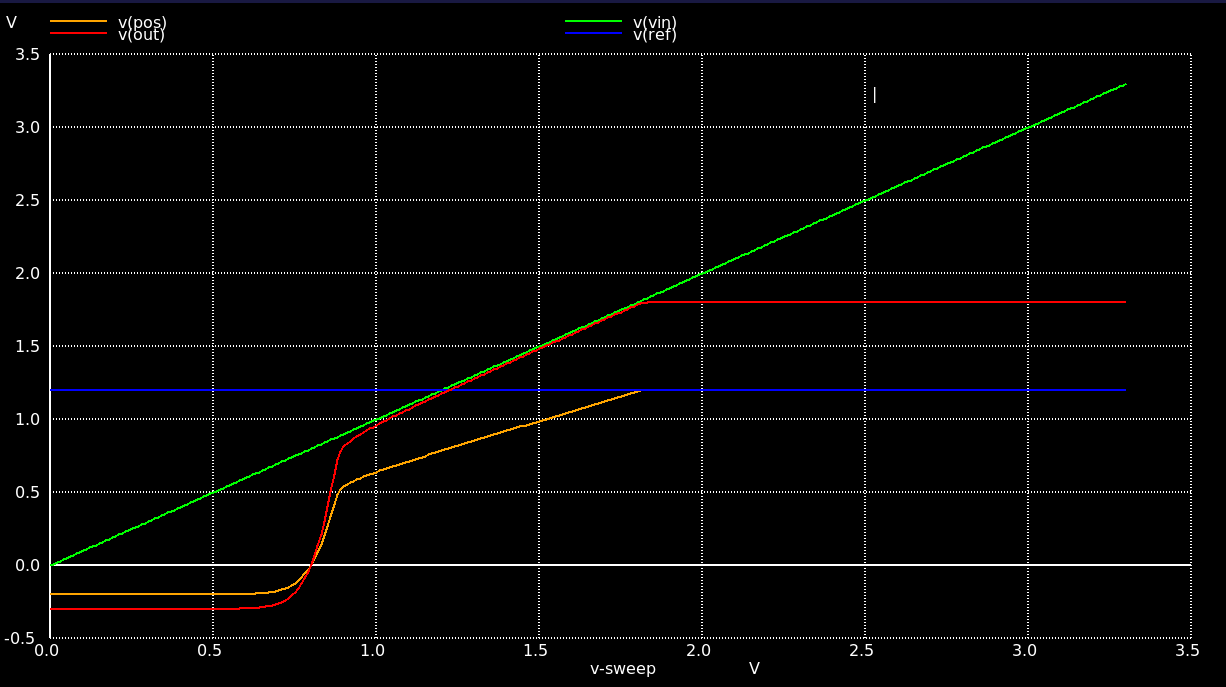 |

# LDO Analysis

### Transient Analysis

In [ ]:
import ngspyce as ns
data = {}

ldo_schematic = project_dir / "ldo_gf180.spice"
ns.source(ldo_schematic)
ns.destroy()

ns.cmd("save all")
ns.cmd("tran 100ns 40us")
print(ns.vector_names())
plt.plot(ns.vector("@il[current]"))

data["time"]      = ns.vector("time")
data["vout"]      = ns.vector("v(out)")
data["vref"]      = ns.vector("v(ref)")
data["vpos"]      = ns.vector("v(pos)")
data["vin"]       = ns.vector("v(vin)")
data["v(op_out)"] = ns.vector("v(op_out)")
data["i(v3)"]     = ns.vector("i(v3)")

np.savez(data_dir / "ldo-transient.npz", **data)

dict_keys(['time', 'vout', 'vref', 'vpos', 'vin', 'v(op_out)', 'i(v3)'])


/tmp/ipykernel_54/2770152112.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_54/2770152112.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


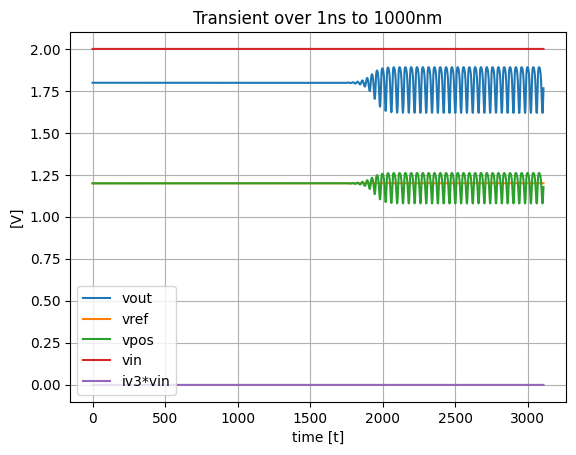

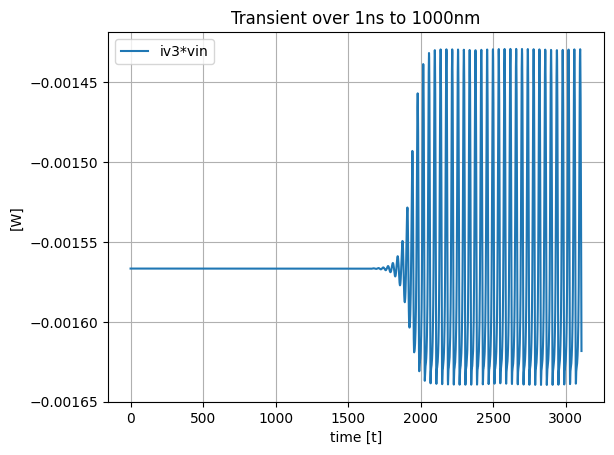

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

_ = np.load(data_dir / "ldo-transient.npz")
data = {key: _[key] for key in _}
pprint(data.keys())

vout = data['vout']
vref = data['vref']
vpos = data['vpos']
vin = data['vin']
vop_out = data['v(op_out)']
iv3 = data['i(v3)']

# Transcient ov Vout Vref Vpos and Vin
fig, ax1 = plt.subplots()

ax1.plot(vout, label="vout")
ax1.plot(vref, label="vref")
ax1.plot(vpos, label="vpos")
ax1.plot(vin, label="vin")
ax1.plot(iv3*vin, label="iv3*vin")

ax1.set_title("Transient over 1ns to 1000nm")
ax1.set_xlabel("time [t]")
ax1.set_ylabel("[V]")
ax1.grid()
ax1.legend()

fig.show()
fig.savefig(img_dir / "transient.png")

# Transcient ov I(V3) over Vin
fig, ax1 = plt.subplots()

ax1.plot(iv3*vin, label="iv3*vin")

ax1.set_title("Transient over 1ns to 1000nm")
ax1.set_xlabel("time [t]")
ax1.set_ylabel("[W]")
ax1.grid()
ax1.legend()

fig.show()
fig.savefig(img_dir / "transient-power.png")

### Supply Sweep

In [13]:
data = {}

ldo_schematic = project_dir / "ldo_gf180.spice"
ns.source(ldo_schematic)
ns.destroy()

ns.cmd("save all")
#ns.dc("V3", 0, 3.3, 0.01)
#ns.cmd("dc V3 0 3.3 0.01")
print(ns.vector_names())

data["vout"]      = ns.vector("v(out)")
data["vref"]      = ns.vector("v(ref)")
data["vpos"]      = ns.vector("v(pos)")
data["vin"]       = ns.vector("v(vin)")
data["v(op_out)"] = ns.vector("v(op_out)")
data["i(v3)"]     = ns.vector("i(v3)")

np.savez(data_dir / "ldo-sweep.npz", **data)

ERROR:ngspyce.sharedspice:Warning: m=xx on .subckt line will override multiplier m hierarchy!
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-03 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-04 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   5.6234E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   2.3714E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   6.4938E-06 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   1.7154E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   2.1870E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.9369E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   2.1216E-05 Note: One successful gmin step

ValueError: cannot reshape array of size 1 into shape (331,)

### PSRR Analysis (NOT FINISHED)

In [ ]:
data = {}

ldo_schematic = project_dir / "ldo_gf180.spice"
ns.source(ldo_schematic)

ns.cmd("save all")
ns.cmd("tran 1ns 2us")

# *alter V3 AC =1
# *ac dec 100 1 1G
# *plot vdb(out)
# *let gm0=@m.xm0.m0[gm]
# *let Zout=(1.5)/(gm0*v(op_out))
# *let Zout2=v(out)/gm0
# *plot vdb(Zout2)
# *wrdata /foss/designs/LDO_Design/data/data_PSRR.dat vdb(out)

data["vout"]      = ns.vector("v(out)")
data["vref"]      = ns.vector("v(ref)")
data["vpos"]      = ns.vector("v(pos)")
data["vin"]       = ns.vector("v(vin)")
data["v(op_out)"] = ns.vector("v(op_out)")
data["i(v3)"]     = ns.vector("i(v3)")

np.savez(data_dir / "ldo-sweep.npz", **data)

### Stability Analysis

~~~spice
*alter IL 0
*alter Vs AC =0
*alter Vt AC=1

*ac dec 10 1 1G

*plot vdb(out)
*plot (180/pi)*vp(out)

*let ph= (180/pi)*vp(out)

*meas ac pm FIND ph WHEN vdb(out)=0
~~~

In [11]:
data = {}

ldo_schematic = project_dir / "ldo_gf180.spice"
ns.source(ldo_schematic)

ns.ac("dec", 100, 1, 1e12)

data["freq"] = np.abs(ns.vector('frequency'))
data["vout"] = ns.vector('v(out)')

np.savez(data_dir / "ldo-stability.npz", **data)

ERROR:ngspyce.sharedspice:Warning: m=xx on .subckt line will override multiplier m hierarchy!
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-03 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-04 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   5.6234E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   2.3714E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   6.4938E-06 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   1.7154E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   2.1870E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.9369E-05 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   2.1216E-05 Note: One successful gmin step

RuntimeError: Vector v(out) not found

### Item A

Utilizando el archivo de simulación `nmmos_intrinsic_gain`, genere la **curva de ganancia intrínseca versus $V_{DS}$** para distintos largos de canal.

In [2]:
# No es necesario ejecutar esto múltiples veces, ya que el modelo se reinicia con "destroy" (supongo).


ERROR:ngspyce.sharedspice:Warning: m=xx on .subckt line will override multiplier m hierarchy!
ERROR:ngspyce.sharedspice:Can't open viewport for graphics.
ERROR:ngspyce.sharedspice:Can't open viewport for graphics.


In [8]:
data = {}

nmos_schematic = project_dir / "nmos_intrinsic_gain_IPD413HW1.spice"
ns.source(nmos_schematic)

for l in (.15, .225, .25, .275, .3, .375, .45 , .525, .75, 1.05):
    ns.destroy()
    ns.cmd(f"alterparam l = {l}")
    ns.cmd("reset")

    print("Analysing nmos with l =", ns.device_state("m.xm1.msky130_fd_pr__nfet_01v8")["l"], "m")

    ns.cmd("save all")
    ns.cmd(save_cmd("m1", "gm"))
    ns.cmd(save_cmd("m1", "gds"))

    ns.dc("vds", 0.07, 1.8, 0.01)

    ns.cmd("let curve=abs(1/deriv(v(g1)))")
    #data[f"L ={l: .3} $\mu$m"] = ns.vector("curve").copy()

    data[f"l={l: .3}"] = ns.vector(sky_retrieve("m1", "gm")) / ns.vector(sky_retrieve("m1", "gds"))

data["v-sweep"] = ns.vector("v-sweep")

np.savez("p3_a.npz", **data)


ERROR:ngspyce.sharedspice:Command 'source' failed:
ERROR:ngspyce.sharedspice:/headless/.xschem/simulations/nmos_intrinsic_gain_IPD413HW1.spice: Resource temporarily unavailable
ERROR:ngspyce.sharedspice:Simulation interrupted due to error!
ERROR:ngspyce.sharedspice:Error: ngspice.dll cannot recover and awaits to be detached
Exception ignored on converting result of ctypes callback function: <function controlled_exit at 0x7efd88378820>
Traceback (most recent call last):
  File "/foss/tools/ngspyce/154a272/local/lib/python3.10/dist-packages/ngspyce/ngspyce.py", line 79, in cmd
    spice.ngSpice_Command(command.encode('ascii'))
TypeError: 'NoneType' object cannot be interpreted as an integer
ERROR:ngspyce.sharedspice:Error: parameter 'l' not found,
ERROR:ngspyce.sharedspice:command 'alterparam' skipped


KeyError: 'l'

dict_keys(['l= 0.15', 'l= 0.225', 'l= 0.25', 'l= 0.275', 'l= 0.3', 'l= 0.375', 'l= 0.45', 'l= 0.525', 'l= 0.75', 'l= 1.05', 'v-sweep'])


/tmp/ipykernel_496/997284352.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_496/997284352.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


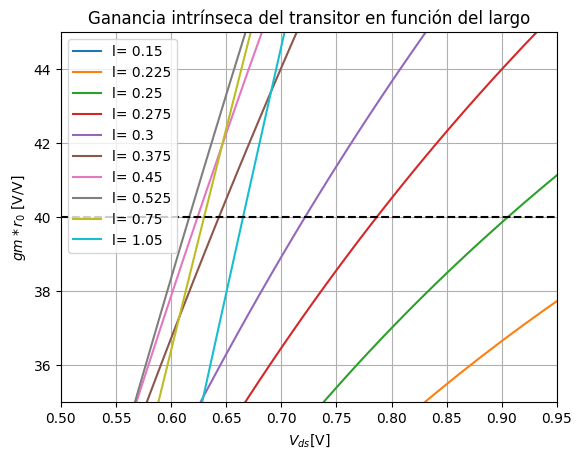

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

_ = np.load("p3_a.npz")
data = {key: _[key] for key in _}
pprint(data.keys())

sweep = data["v-sweep"].copy()
del data["v-sweep"]

fig, ax1 = plt.subplots()

for key, value in data.items():
    ax1.plot(sweep, value, label=key)

ax1.axhline(40, color="black", linestyle="dashed")

ax1.set_title("Ganancia intrínseca del transitor en función del largo")
ax1.set_xlabel("$V_{ds}$[V]")
ax1.set_ylabel("$gm * r_0$ [V/V]")
ax1.grid()
ax1.legend()

fig.show()
fig.savefig("p3-a-1.png")

ax1.set_xlim(.5, .95)
ax1.set_ylim(35, 45)

fig.show()
fig.savefig("p3-a-2.png")

### Item D

Utilice el archivo `cs_amp_full.sch` para verificar la performance del circuito diseñado. Grafique diagrama de Bode en amplitud y fase e interprete los datos.

In [5]:
data = {}

# Analysis
cs_amplifier_schematic = project_dir / "cs_amp_full_IPD413HW1-v2.spice"
ns.source(cs_amplifier_schematic)

ns.ac("dec", 100, 1, 1e12)

data["freq"] = np.abs(ns.vector('frequency'))
data["vout"] = ns.vector('vout')

np.savez("p3_d.npz", **data)

ERROR:ngspyce.sharedspice:Warning: m=xx on .subckt line will override multiplier m hierarchy!
ERROR:ngspyce.sharedspice:Can't open viewport for graphics.
ERROR:ngspyce.sharedspice:Can't open viewport for graphics.


dict_keys(['freq', 'vout'])


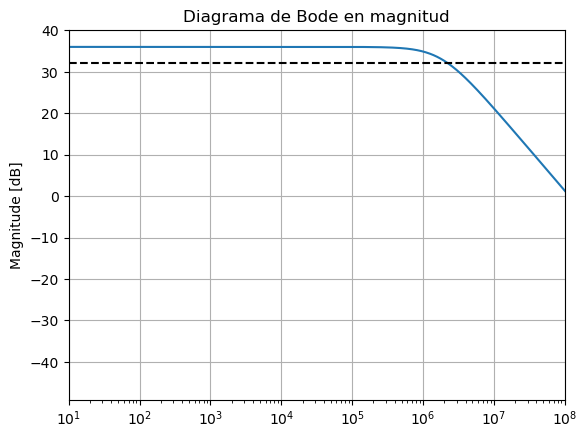

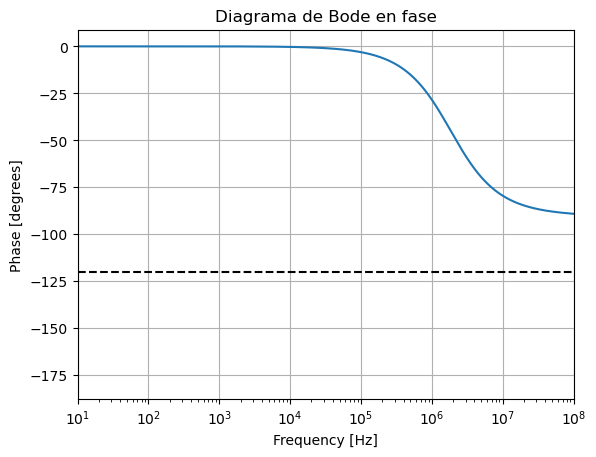

In [25]:
_ = np.load("p3_d.npz")
data = {key: _[key] for key in _}
pprint(data.keys())

freq = data["freq"]
vout = data["vout"]


# Magnitude Diagram
###################
fig, ax1 = plt.subplots()
ax1.set_title("Diagrama de Bode en magnitud")
ax1.grid()
ax1.set_xlim(10**1, 10**8)
ax1.semilogx(freq, 20*np.log10(np.abs(vout)))
ax1.axhline(20*np.log10(40), color="black", linestyle="dashed")
ax1.set_ylabel('Magnitude [dB]')
fig.savefig("p3-d-1.png")


# Phase Diagram
###############
fig, ax2 = plt.subplots()
ax2.set_title("Diagrama de Bode en fase")
ax2.grid()
ax2.set_xlim(10**1, 10**8)
ax2.semilogx(freq, np.angle(vout, True))
ax2.axhline(-180+60, color="black", linestyle="dashed")
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase [degrees]')
ax2.margins(x=0)
fig.savefig("p3-d-2.png")